# **คณันสักก์ สุจารีย์ 163404140001 วต.3-1**

# TrainCNN for Medical Waste Classification(EfficientNetB2)_FreezModel_No-ClassImbalance

In [ ]:
!nvidia-smi

Thu Sep 29 09:06:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
'''
Lab Image Classification (CNN) -> Digital Image Processing / CoE RMUTSV / AJ.Gorn
using several images of Medical Waste Dataset from AIDI LAB CoE RMUTSV
'''

'\nLab Image Classification (CNN) -> Digital Image Processing / CoE RMUTSV / AJ.Gorn\nusing several images of Medical Waste Dataset from AIDI LAB CoE RMUTSV\n'

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np

## Download Dataset

In [4]:
!wget https://assets.gezdev.com/dip/MedWasteImagesDataset.tar.gz

--2022-09-29 09:09:22--  https://assets.gezdev.com/dip/MedWasteImagesDataset.tar.gz
Resolving assets.gezdev.com (assets.gezdev.com)... 203.158.180.101
Connecting to assets.gezdev.com (assets.gezdev.com)|203.158.180.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1399829355 (1.3G) [application/octet-stream]
Saving to: ‘MedWasteImagesDataset.tar.gz’

MedWasteImagesDatas 100%[===================>]   1.30G  5.26MB/s    in 4m 33s  

2022-09-29 09:13:57 (4.88 MB/s) - ‘MedWasteImagesDataset.tar.gz’ saved [1399829355/1399829355]



In [5]:
!tar -xvf MedWasteImagesDataset.tar.gz

MedWasteImagesDataset/
MedWasteImagesDataset/Test/
MedWasteImagesDataset/Test/Glove/
MedWasteImagesDataset/Test/Glove/Glove_13.png
MedWasteImagesDataset/Test/Glove/Glove_14.png
MedWasteImagesDataset/Test/Glove/Glove_15.png
MedWasteImagesDataset/Test/Glove/Glove_16.png
MedWasteImagesDataset/Test/Glove/Glove_17.png
MedWasteImagesDataset/Test/Glove/Glove_18.png
MedWasteImagesDataset/Test/Glove/Glove_19.png
MedWasteImagesDataset/Test/Glove/Glove_20.png
MedWasteImagesDataset/Test/Glove/Glove_21.png
MedWasteImagesDataset/Test/Glove/Glove_22.png
MedWasteImagesDataset/Test/Glove/Glove_23.png
MedWasteImagesDataset/Test/Glove/Glove_24.png
MedWasteImagesDataset/Test/Glove/Glove_25.png
MedWasteImagesDataset/Test/Glove/Glove_26.png
MedWasteImagesDataset/Test/Glove/Glove_27.png
MedWasteImagesDataset/Test/Glove/Glove_28.png
MedWasteImagesDataset/Test/Glove/Glove_29.png
MedWasteImagesDataset/Test/Glove/Glove_30.png
MedWasteImagesDataset/Test/Glove/Glove_31.png
MedWasteImagesDataset/Test/Glove/Glove_32

## Define ImageSize / BatchSize for Training Model

In [6]:
img_height=260
img_width=260
batch_size=32 #เกี่ยวกับเรื่องแรม

## Training Set DIR

In [7]:
train_dataset_path='/content/MedWasteImagesDataset/Train/'

## Testing Set DIR

In [8]:
test_dataset_path='/content/MedWasteImagesDataset/Test/'

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 244 files belonging to 6 classes.
Using 196 files for training.


In [10]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['Glove', 'Mask', 'OxygenMask', 'Syringe', 'UrineBag', 'Vaccinebottle']
number of class = 6


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 244 files belonging to 6 classes.
Using 48 files for validation.


In [12]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 139 files belonging to 6 classes.


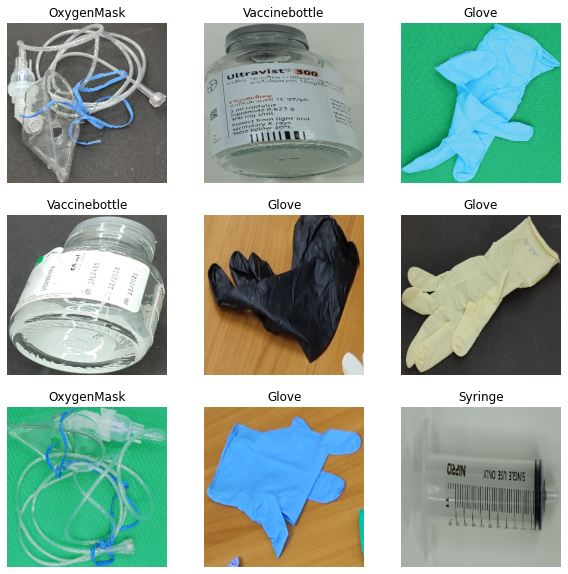

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Augmentation & Dataset Preparation

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [15]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.

  # ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE) # if using EfficientNet -> Normalize Layer will already included in the model

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [17]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 260, 260, 3)
(32,)


## Load Model Architecture with Transfer Learning of EfficientNetB2 from imagenet

In [18]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB2,preprocess_input

efficientnetB2_model = keras.applications.EfficientNetB2(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

efficientnetB2_model_nooutput = efficientnetB2_model.layers[-3].output
custom_efficientnetB2_model = Model(inputs = efficientnetB2_model.input, outputs = efficientnetB2_model_nooutput)


37445632/37432240 [==============================] - 0s 0us/step


### Freez Extractor+

In [19]:
## Freez EfficientnetB2
custom_efficientnetB2_model.trainable = False
for layer in custom_efficientnetB2_model.layers:
    layer.trainable = False
print(custom_efficientnetB2_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 260, 260, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 260, 260, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 261, 261, 3)  0           ['normalization[0][0]']      

In [20]:
tf.keras.utils.plot_model(custom_efficientnetB2_model, to_file="EfficientnetB2Output.png", show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

## Add custom Dense Layer and Dropout(Overfitting Prevention)

In [21]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_efficientnetB2_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1408)              7768569   
                                                                 
 dense (Dense)               (None, 1024)              1442816   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 9,217,535
Trainable params: 1,448,966
Non-trainable params: 7,768,569
_________________________________________________________________


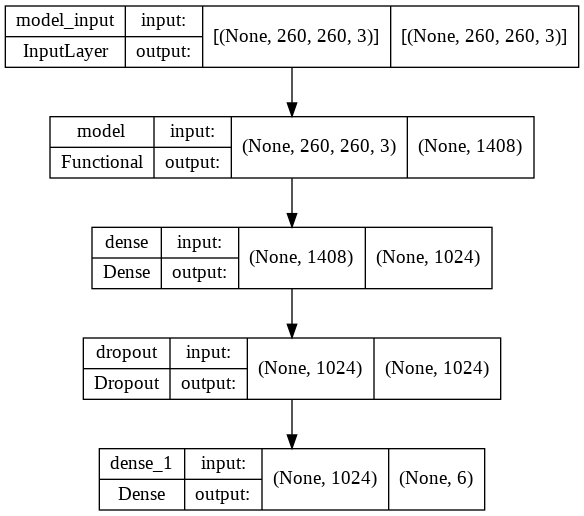

In [23]:
#print(len(model.layers))
tf.keras.utils.plot_model(model, to_file="FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

### Connect Google Drive for keep trained model

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
path_to_model = '/content/drive/MyDrive/MedEfficientNetB2_Model/'

## Train Model

In [29]:
EPOCHS = 10
save_model_interval = 5
checkpoint_filepath = path_to_model+'MedEfficientNetB2-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/10
7/7 [==============================] - 10s 488ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0136 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
7/7 [==============================] - 1s 144ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
7/7 [==============================] - 1s 145ms/step - loss: 7.2486e-04 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
7/7 [==============================] - 1s 145ms/step - loss: 4.4204e-04 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
7/7 [==============================] - ETA: 0s - loss: 7.4027e-04 - accuracy: 1.0000

7/7 [==============================] - 23s 4s/step - loss: 7.4027e-04 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
7/7 [==============================] - 1s 146ms/step - loss: 4.5995e-04 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
7/7 [==============================] - 1s 146ms/step - loss: 5.4708e-04 - accuracy: 1.0000 - val_loss: 0.0126 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 8/10
7/7 [==============================] - 1s 146ms/step - loss: 6.7894e-04 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 9/10
7/7 [==============================] - ETA: 0s - loss: 4.8708e-04 - accuracy: 1.0000
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
7/7 [==============================] - 1s 146ms/step - loss: 4.8708e-04 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 10/10
7/7 [==============================] - ETA: 0s - loss:

7/7 [==============================] - 23s 4s/step - loss: 3.8208e-04 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 1.0000 - lr: 2.0000e-04


Text(0.5, 1.0, 'Training and Validation Accuracy')

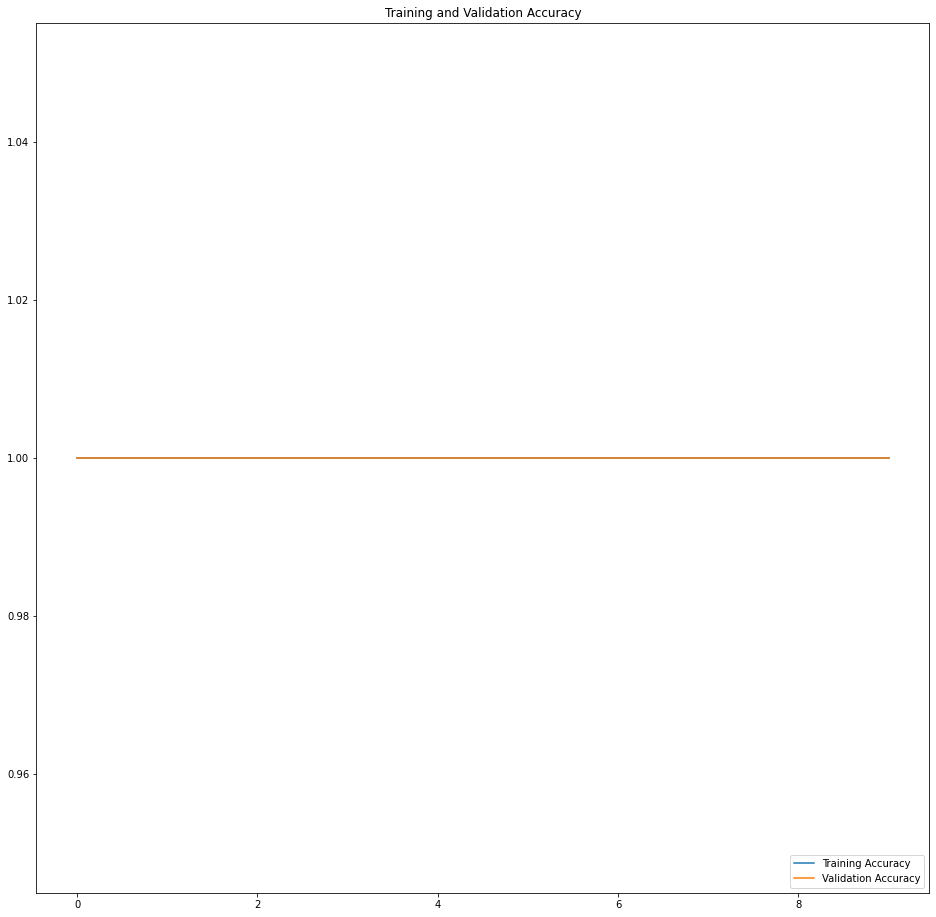

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


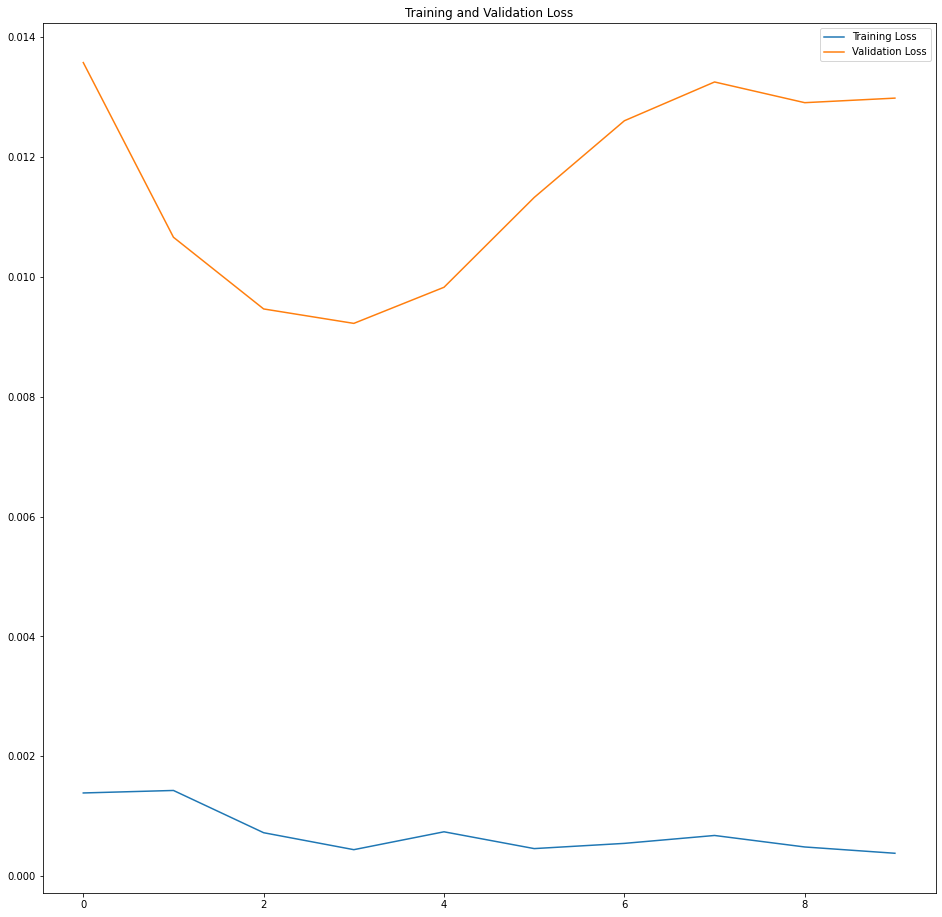

In [31]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
#indoor testset
test_ds_results = model.evaluate(test_ds)
print("test_ds_results:test loss, test acc:", test_ds_results)

5/5 [==============================] - 8s 305ms/step - loss: 0.1232 - accuracy: 0.9640
test_ds_results:test loss, test acc: [0.12316716462373734, 0.9640287756919861]


# Testing in Testset

In [33]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['/content/drive/MyDrive/MedEfficientNetB2_Model/MedEfficientNetB2-epoch0005.pb',
 '/content/drive/MyDrive/MedEfficientNetB2_Model/MedEfficientNetB2-epoch0010.pb']

In [34]:
test_acc = []
test_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    test_results = loaded_model.evaluate(test_ds)
    test_loss.append(test_results[0]) # append loss
    test_acc.append(test_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_acc={test_acc[lm_idx]} \n")

5/5 [==============================] - 2s 113ms/step - loss: 0.1098 - accuracy: 0.9784
Epoch005 
 test_acc=0.9784172773361206 

5/5 [==============================] - 2s 113ms/step - loss: 0.1232 - accuracy: 0.9640
Epoch010 
 test_acc=0.9640287756919861 



range(5, 15, 5)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

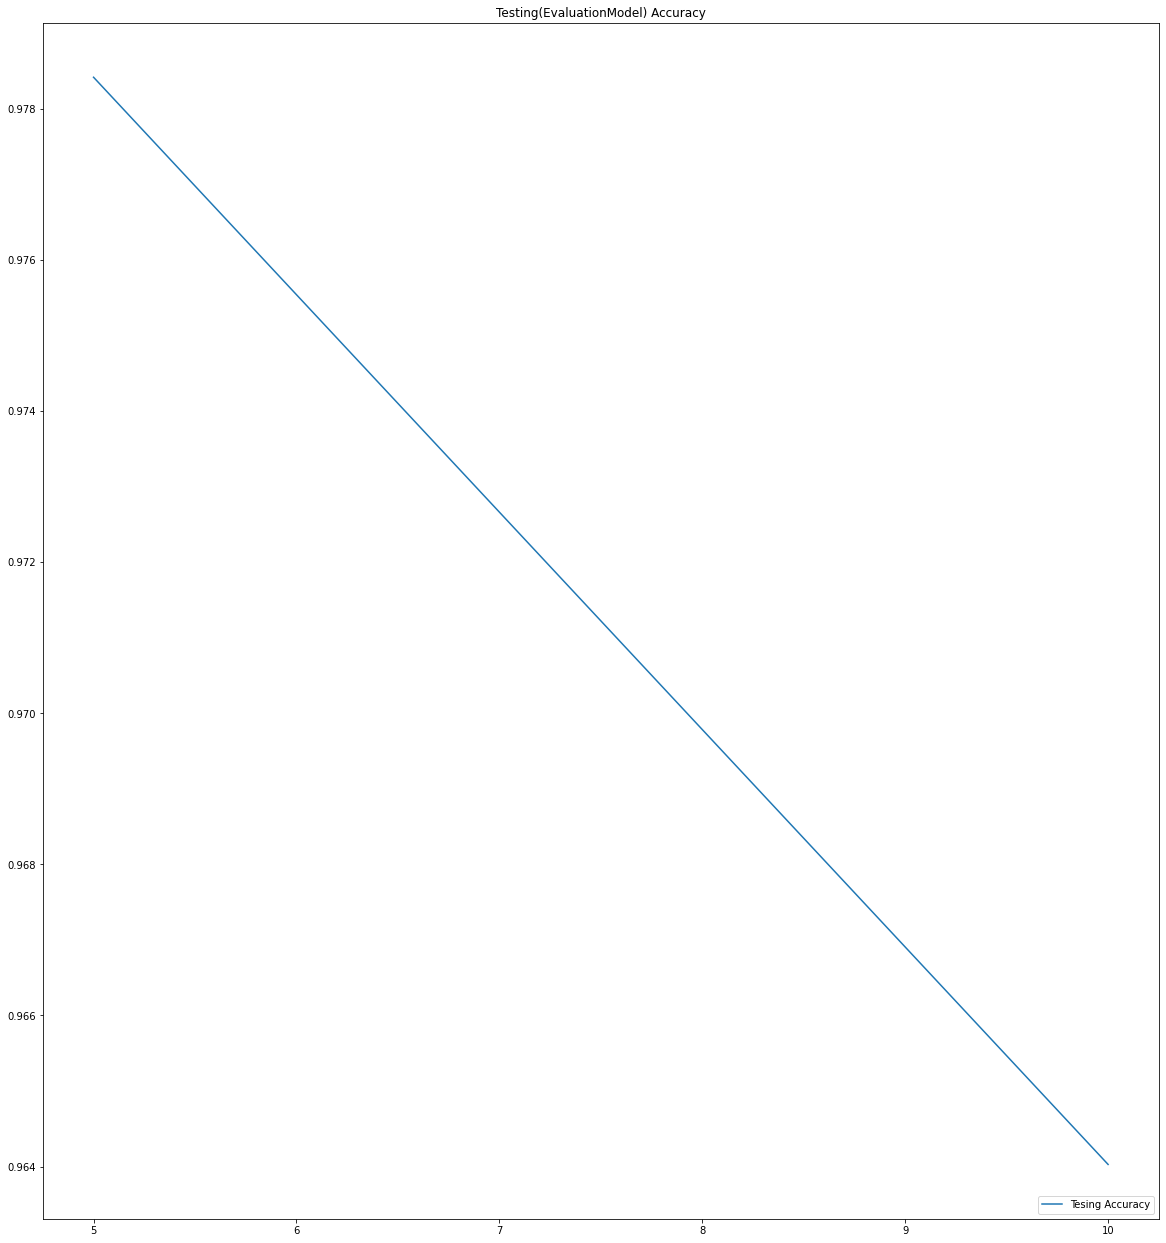

In [35]:
# loss / acc in each epoch graph ploting
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_acc, label='Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [36]:
#Find Max Index and Value
print(f"max acc -> {max(test_acc)}")
max_index = test_acc.index(max(test_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.9784172773361206
max index -> 0
The [Epoch] of max acc -> 5


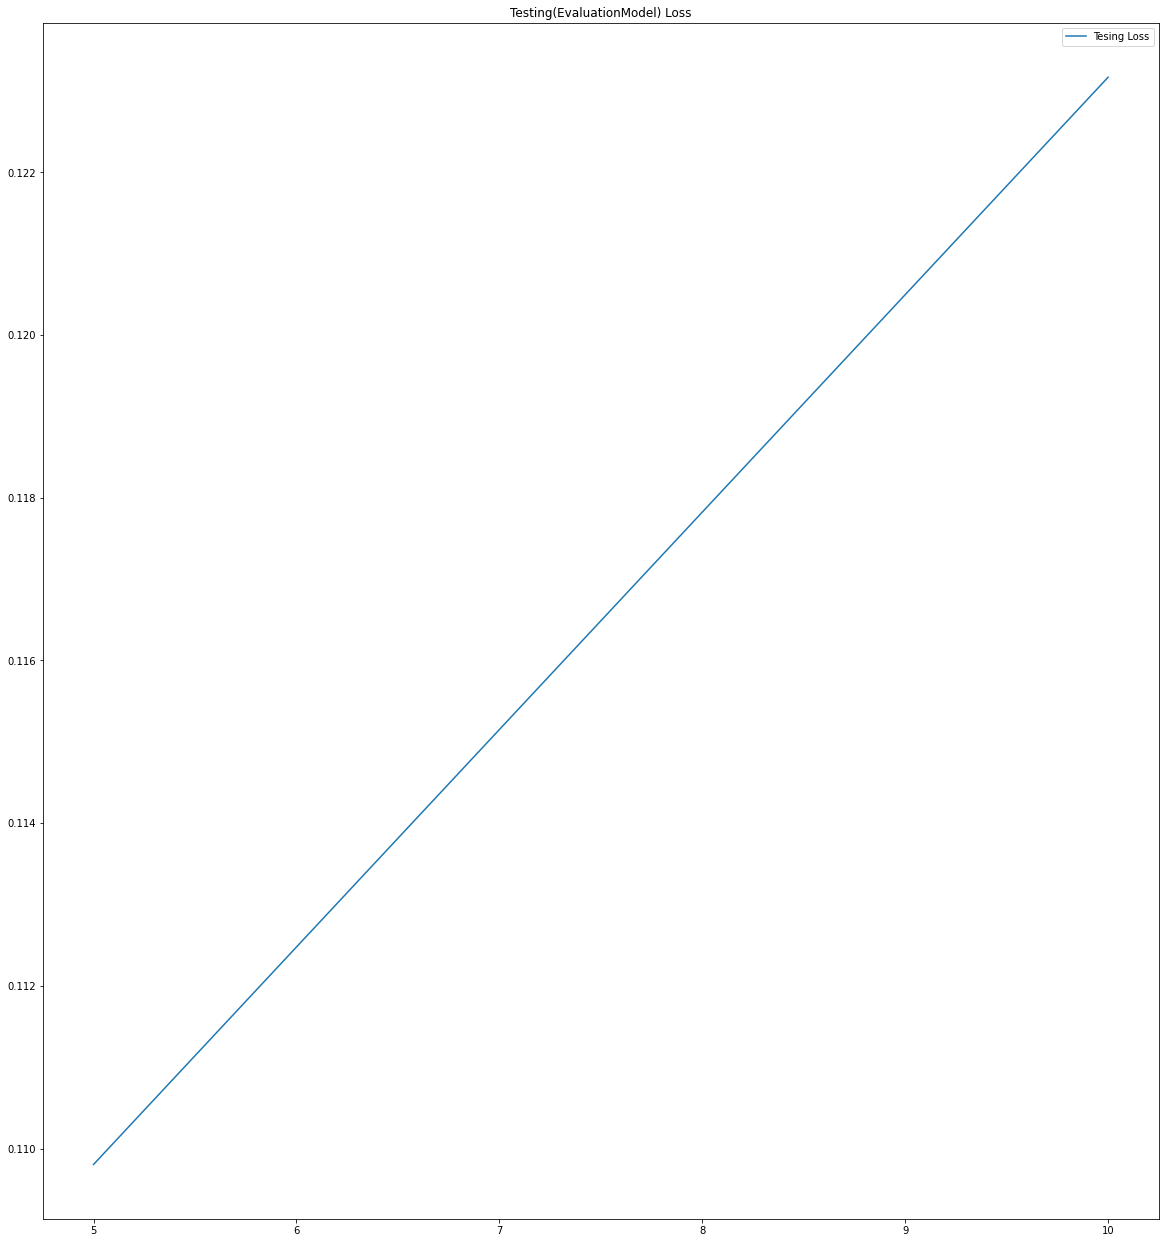

In [37]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_loss, label='Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [38]:
test_acc

[0.9784172773361206, 0.9640287756919861]

In [39]:
test_loss

[0.10980580002069473, 0.12316711992025375]

## Load Best Model and Testing in each class

In [40]:
# Del dataset memory and reload best acc model
# RAM
del train_ds
del val_ds

In [41]:
loaded_model = tf.keras.models.load_model(models_paths[max_index])
print(f"Loaded {models_paths[max_index]} (Maximun Acc)")
batch_size=8

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE

x_test = np.concatenate([ x for x,y in test_ds],axis=0)
y_test = np.concatenate([ y for x,y in test_ds],axis=0)

print(f"Amount of testing data x,y : {len(x_test)},{len(y_test)}")

# let's predict
y_all_predicted = loaded_model.predict(x_test,batch_size=batch_size)


Loaded /content/drive/MyDrive/MedEfficientNetB2_Model/MedEfficientNetB2-epoch0005.pb (Maximun Acc)
Amount of testing data x,y : 139,139


In [42]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_test)):
    if(y_test[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'All Data = {TP+FP}')
print(f'True Positive = {TP}')
print(f'False Positive = {FP}')
print(f'Accuracy = {TP/(TP+FP)*100} %')

# acc eachclass
TP_eachclass = [0] * len(class_names)
FP_eachclass = [0] * len(class_names)
for i in range(len(y_test)):
    if(y_test[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_test[i]] = TP_eachclass[y_test[i]] + 1
    else :
        FP_eachclass[y_test[i]] = FP_eachclass[y_test[i]] + 1
#recheck
print(f'All number (Processed) = {sum(TP_eachclass)+sum(FP_eachclass)}')

All Data = 139
True Positive = 136
False Positive = 3
Accuracy = 97.84172661870504 %
All number (Processed) = 139


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


## Accuracy in each class

In [43]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


Glove acc = 100.0%
Mask acc = 100.0%
OxygenMask acc = 100.0%
Syringe acc = 100.0%
UrineBag acc = 85.71428571428571%
Vaccinebottle acc = 100.0%



all_avg_eachclass = 97.61904761904763%


In [44]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_test, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[27,  0,  0,  0,  0,  0],
       [ 0, 23,  0,  0,  0,  0],
       [ 0,  0, 21,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0],
       [ 3,  0,  0,  0, 18,  0],
       [ 0,  0,  0,  0,  0, 15]])

In [45]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[100.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        , 100.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 100.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , 100.        ,
          0.        ,   0.        ],
       [ 14.28571429,   0.        ,   0.        ,   0.        ,
         85.71428571,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 100.        ]])

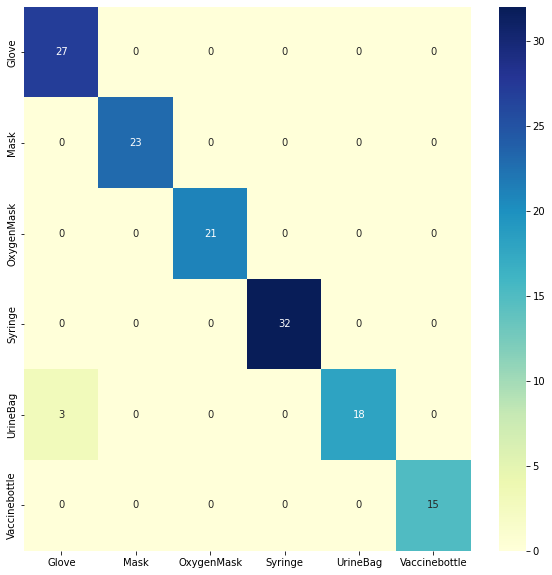

In [46]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

## Plot Confusion Matrix

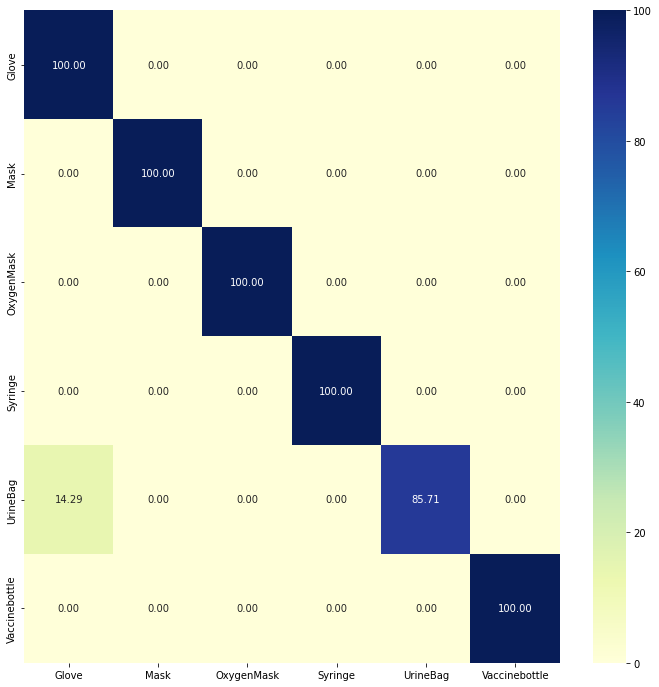

In [47]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (12,12))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")

## Show Predicted Result in Each A Test Image

In [48]:
from PIL import Image
import glob
test_image_paths = glob.glob(test_dataset_path+'**/*.png')

In [49]:
print(test_image_paths)

['/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_1.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_6.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_14.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_5.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_3.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_8.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_15.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_10.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_12.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_4.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_2.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_13.png', '/content/MedWasteImagesDataset/Test/Vaccinebottle/Vaccinebottle_7.png', '/content/MedWasteImagesDataset/Test/Vaccineb

*** Warning : Answer will not same the test_ds, that loaded by tensorflow, because below code load / resize image by using different algorithm.

In [50]:
import cv2 as cv
for i,test_image_path in enumerate(test_image_paths):
  cvImg = cv.imread(test_image_path)
  cvImg = cv.resize(cvImg,(img_width,img_height),interpolation=cv.INTER_AREA) # custom interpolation
  img_array = np.array(cvImg) # convert 2 np array
  # img_array = img_array/255.0 # uncomment if must be normalize image by 255.0
  img_array_expanded = np.expand_dims(img_array, axis=0) # Expand dimensions to match the 4D Tensor shape.
  ans = loaded_model.predict(img_array_expanded)
  max_ans = np.argmax(ans)
  max_conf = np.max(ans)*100.0
  plt.axis("off")
  plt.imshow(cv.cvtColor(cvImg, cv.COLOR_BGR2RGB))
  plt.title(class_names[max_ans]+' ('+str(max_conf)+')'+'%')
  plt.show()
  print('_________________________________________')
  

Output hidden; open in https://colab.research.google.com to view.